A controlled trial of two nucleoside analogues plus indinavir in persons with human immunodeficiency virus infection and CD4 cell counts of 200 per cubic millimeter or less. The New England Journal of Medicine, 1997. https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [41]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sksurv.util import Surv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.metrics import integrated_brier_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sksurv.ensemble import RandomSurvivalForest
from SurvSet.data import SurvLoader

import src

SEED = 1234
np.random.seed(SEED)

In [2]:
loader = SurvLoader()
enc_num = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
sel_num = make_column_selector(pattern='^num\\_')
enc_df = ColumnTransformer(transformers=[('s', enc_num, sel_num)])
enc_df.set_output(transform='pandas')

,transformers,"[('s', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [ ]:
df = loader.load_dataset(ds_name="actg")['df'].set_index("pid")
senc = Surv()
So = senc.from_arrays(df['event'].astype(bool), df['time'])
enc_df.fit(df)
X_train = enc_df.transform(df)
X_train = X_train.loc[:, X_train.columns.str.startswith("s__num_")]
X_train.columns = X_train.columns.str.replace("s__num_", "")

Visualize the 4 numerical features w.r.t. the random treatment.

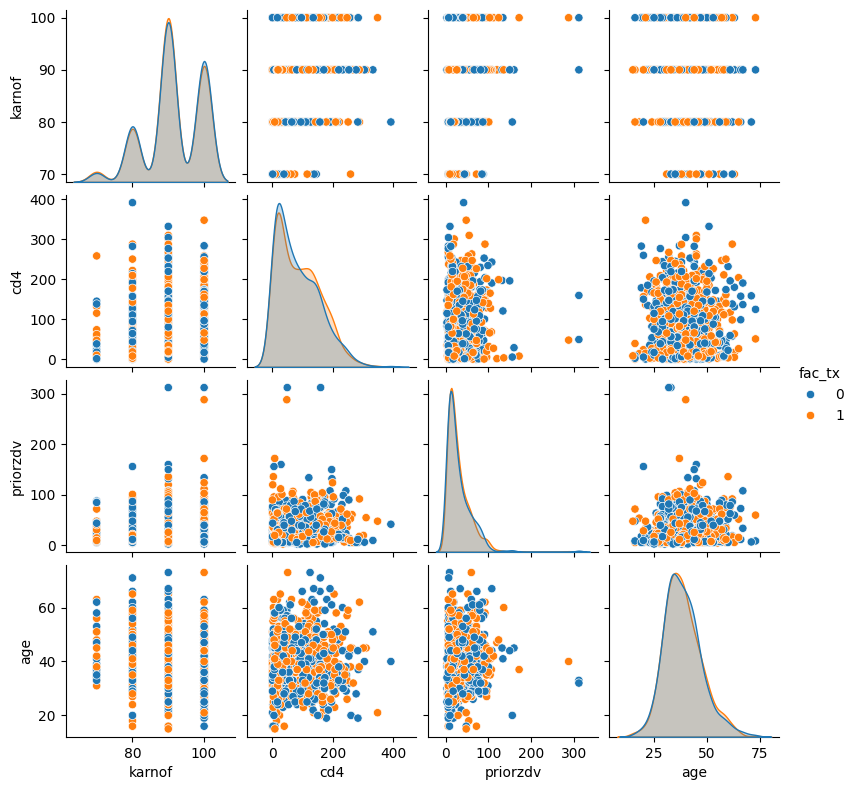

In [36]:
sns.pairplot(pd.concat([X_train, df.fac_tx], axis=1), hue="fac_tx", height=2)

In [33]:
model = RandomSurvivalForest(max_depth=6, n_estimators=300, oob_score=True, random_state=SEED)
model.fit(X=X_train.values, y=So)
print(f'train score: {model.score(X_train.values, So):.04f} | OOB score: {model.oob_score_:.04f}')

train score: 0.9139 | OOB score: 0.7234


In [38]:
np.random.seed(SEED)
n_samples = 200
if X_train.shape[0] > n_samples:
    X_explain = X_train.sample(n_samples)
else:
    n_samples = X_train.shape[0]
    X_explain = X_train
explanations_order2 = src.survshapiq(
    model, 
    X_train.values, 
    [X_explain.iloc[[i]] for i in range(0, X_explain.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="k-SII",
    approximator="auto",
    max_order=2
)

100%|██████████| 200/200 [49:38<00:00, 14.89s/it]


In [42]:
filename = f'results/actg_explanations_order2.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order2, f)

In [43]:
np.random.seed(SEED)
n_samples = 200
if X_train.shape[0] > n_samples:
    X_explain = X_train.sample(n_samples)
else:
    n_samples = X_train.shape[0]
    X_explain = X_train
explanations_order1 = src.survshapiq(
    model, 
    X_train.values, 
    [X_explain.iloc[[i]] for i in range(0, X_explain.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="SV",
    approximator="auto",
    max_order=1
)

100%|██████████| 200/200 [51:57<00:00, 15.59s/it]


In [44]:
filename = f'results/actg_explanations_order1.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order1, f)

In [48]:
CBF_COLORS = [
    "#0072B2", "#E69F00", "#009E73", "#D55E00",
    "#CC79A7", "#F0E442", "#56B4E9", "#999999"
]

In [ ]:
timepoints = src.get_evenly_spaced_integers(model.unique_times_, 41)

In [169]:
# treatment = df.fac_tx[X_explain.index].values
# treatment.value_counts()

In [235]:
df_plot1 = pd.concat([explanations_order1[i].assign(time=timepoints, id=i, 
                                                    # treatment=treatment[i]
                                                    ).iloc[:35,:] 
                                                    for i in range(200)])
df_plot1 = pd.melt(df_plot1, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])

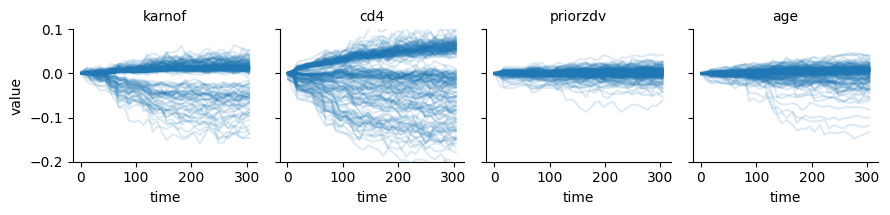

In [249]:
ax = sns.relplot(
    df_plot1, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2.25,
    aspect=1,
    col_wrap=4
    # hue="treatment", palette=sns.color_palette("tab10")
)
ax.set(ylim=(-0.2, 0.1))
# ax.fig.suptitle("SurvSHAP(t) values explaining a random forest predicting survival of patients treating the HIV-1 infection", y=0.95)
# sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
# plt.title(f'')
ax.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.savefig(f'results/actg_order1_global.png', bbox_inches="tight")
# plt.clf()

In [237]:
df_plot2 = pd.concat([explanations_order2[i].assign(time=timepoints, id=i, 
                                                    # treatment=treatment[i]
                                                    ).iloc[:35,:] 
                                                    for i in range(200)])
df_plot2 = pd.melt(df_plot2, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])

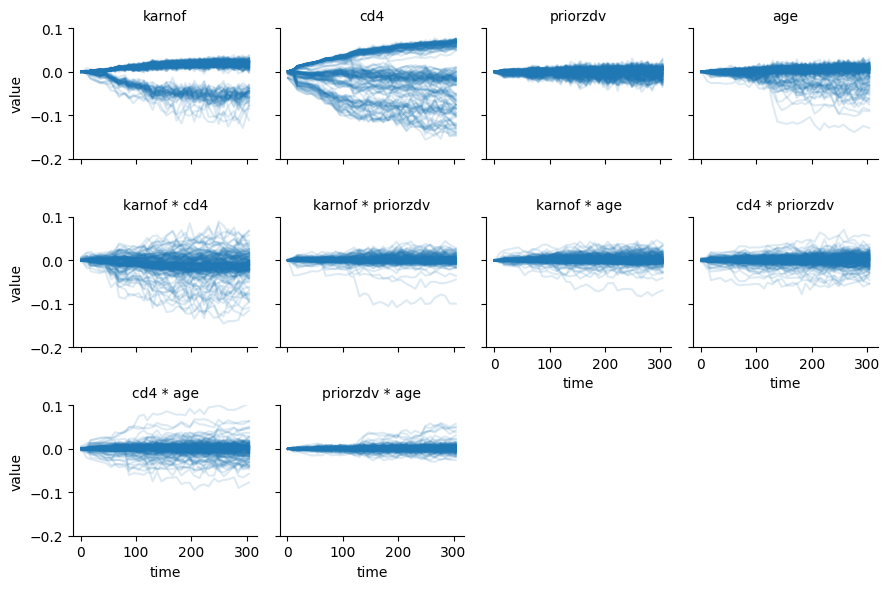

In [250]:
ax = sns.relplot(
    df_plot2, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2,
    aspect=1.125,
    col_wrap=4
    # hue="treatment", palette=sns.color_palette("tab10")
)
ax.set(ylim=(-0.2, 0.1))
# ax.fig.suptitle("SurvSHAP-IQ(t) values", y=0.97)
# sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
# plt.title(f'')
ax.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.savefig(f'results/actg_order2_global.png', bbox_inches="tight")
# plt.clf()